# Convolutional Neural Network

In this notebook I will use a convolutional neural network for image classification and object localization. 
This notebook has 2 parts:

1. Classifiying CIFAR-10.
2. Localization as Regression using transfer learning of ResNet18.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this part, we will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [2]:
# This notebook assumes that directory ./data holds the cifar10 dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
     horse        cat        cat       bird


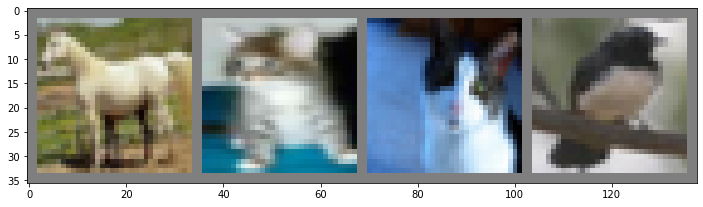

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #.next()
print("Image shape: ", images[0].shape)

# show images
imshow(torchvision.utils.make_grid(images[:4]))

# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # The architechture created was influenced by the VGGnet,
        # this reached the best results after lots of trial and error
        
        self.conv1 = nn.Conv2d(3, 8, 3, padding=0)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=0)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=0)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=0)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        #############################################################################
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of the model.                       #
        #############################################################################
        
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.pool1(x)
        x = torch.nn.functional.relu(self.conv3(x))
        x = torch.nn.functional.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
%%time
#############################################################################
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also.                                                                 # 
#############################################################################

train_loss, train_acc = [], []

for epoch in range(8):                    
    running_loss = 0
    running_corrects = 0
    epoch_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data                                     # get the inputs and labels from the data [inputs, labels]
        optimizer.zero_grad()                                     # initialize gradients to zero
        outputs = net(inputs)                                     # forward calc
        loss = criterion(outputs, labels)                         # loss calc
        loss.backward()                                           # backward calc
        optimizer.step()                                          # update
        _ , predicted = torch.max(outputs, 1)                     # calc predictions
        running_corrects += torch.sum(predicted == labels)        # accumulate correct class preds

        # follow calculations
        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 4000 == 3999:                                      # print every 4000 mini-batches
            print(f'Epoch: {epoch + 1}, Mini Batch: {i + 1:5d}, Loss: {running_loss / 3999:.3f}')
            running_loss = 0.0
            
    train_loss.append(epoch_loss / (len(trainloader)*batch_size))
    train_acc.append(running_corrects.double() / (len(trainloader)*batch_size))
    
print("Learning phase finished")

Epoch: 1, Mini Batch:  4000, Loss: 2.265
Epoch: 1, Mini Batch:  8000, Loss: 1.874
Epoch: 1, Mini Batch: 12000, Loss: 1.669
Epoch: 2, Mini Batch:  4000, Loss: 1.487
Epoch: 2, Mini Batch:  8000, Loss: 1.393
Epoch: 2, Mini Batch: 12000, Loss: 1.291
Epoch: 3, Mini Batch:  4000, Loss: 1.174
Epoch: 3, Mini Batch:  8000, Loss: 1.116
Epoch: 3, Mini Batch: 12000, Loss: 1.061
Epoch: 4, Mini Batch:  4000, Loss: 0.953
Epoch: 4, Mini Batch:  8000, Loss: 0.937
Epoch: 4, Mini Batch: 12000, Loss: 0.912
Epoch: 5, Mini Batch:  4000, Loss: 0.801
Epoch: 5, Mini Batch:  8000, Loss: 0.819
Epoch: 5, Mini Batch: 12000, Loss: 0.810
Epoch: 6, Mini Batch:  4000, Loss: 0.708
Epoch: 6, Mini Batch:  8000, Loss: 0.717
Epoch: 6, Mini Batch: 12000, Loss: 0.734
Epoch: 7, Mini Batch:  4000, Loss: 0.620
Epoch: 7, Mini Batch:  8000, Loss: 0.643
Epoch: 7, Mini Batch: 12000, Loss: 0.665
Epoch: 8, Mini Batch:  4000, Loss: 0.523
Epoch: 8, Mini Batch:  8000, Loss: 0.592
Epoch: 8, Mini Batch: 12000, Loss: 0.602
Learning phase f

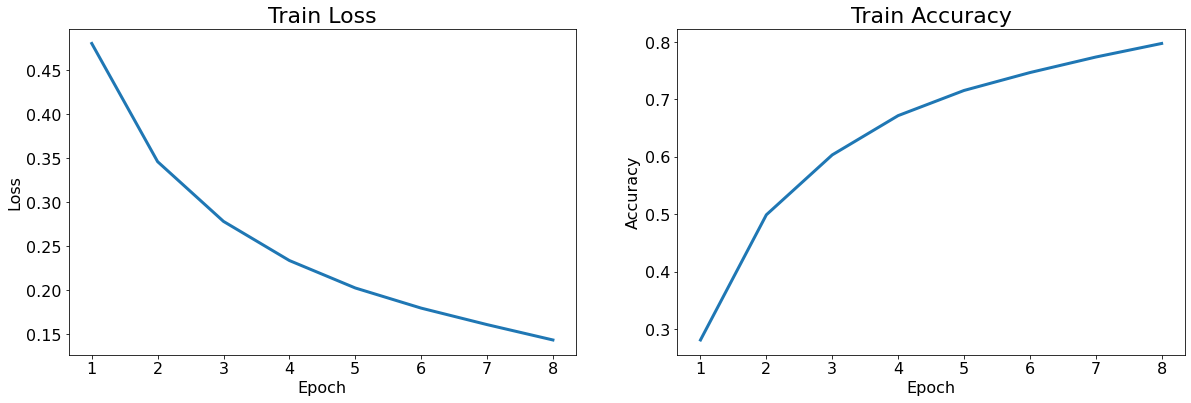

In [6]:
epochs = range(1,9)

fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].set_title('Train Loss',fontsize="22")
ax[0].plot(epochs, train_loss, linewidth=3, label='Training loss')
ax[0].set_xlabel('Epoch', size=16)
ax[0].set_ylabel('Loss', size=16)
ax[0].tick_params(labelsize=16)

ax[1].set_title('Train Accuracy',fontsize="22")
ax[1].plot(epochs, train_acc, linewidth=3, label='Training Accuracy')
ax[1].set_xlabel('Epoch', size=16)
ax[1].set_ylabel('Accuracy', size=16)
ax[1].tick_params(labelsize=16)

plt.show()

## Model evaluation

Calculate the model accuracy and print a confusion matrix where the y axis represents the real category and the x axis represents the predicted category. 

In [7]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################

correct = 0
total = 0

# validation phase, no need to calc gradients
with torch.no_grad():
    net.eval()
    for data in testloader:
        images, labels = data
        outputs = net(images)                       # calculate outputs by running images through the network
        _, predicted = torch.max(outputs.data, 1)   # prediction will be class with highest value 
        for i in range(labels.size(0)):
            confusion_matrix[predicted[i],labels[i]] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

model_accuracy += correct/total * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 70.73%


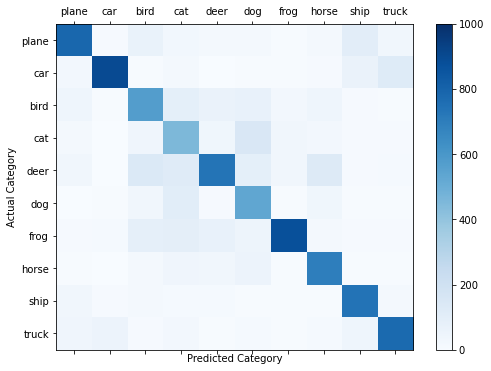

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
cax = ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
fig.colorbar(cax)
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

**Let's describe our experiments.
What parameters have been experimented with? What works and what doesn't? Why?**


I have experimented with both model layers and hyperparameters (batch size, optimizer, lr, epochs)

**Layers** - I tried many permutations changing both layer arangement and channels using the Relu as a non linear activation function. <br>
I got good results using: conv - maxpool - conv - maxpool - fc - fc - fc. <br>
Ultimately based on the VGG architechture I used: conv - conv - maxpool - conv - conv - maxpool - fc - fc - fc. <br>
**Batch size** has a huge impact on accuracy when freezing all the other hyperparametes, increasing from 4 to 16,32,64,128 lowers accuracy to around 20% - this could happen due to overfitting on the batch, the stochastic properties of a small batch works better. <br>
**Momentum** around 0.9 is optimal, above that the accuracy decreases. This could be due to a "hilly" Cost plain, we want momentum to decay fast and avoid bouncing around during gradient decend. <br>
**Epochs** - increasing epochs from 2 to 6 has an increase of around 10% accuracy - this happens due to the model not overfitting and increasing accuracy on general data.

**What can we learn from the confusion matrix? Why do we need additional evaluation methods other than accuracy?**

The confusion matrix helps us understand the models predictions vs the real class. It provides a visual tool to see pairs or even groups that are being misclassified. <br>
For instance it is visible that cars are mistakenly predicted as trucks as oppose to all other classes (could change between training attempts). The same goes for cats-dogs, planes-birds\ships.
In this case we could address these issues more precisely.

# Localization as Regression

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [9]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line.

The first time you run this cell the weights will be downloaded.

In [10]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [11]:
# This notebook assumes that directory ./data/animals holds the animal dataset with annotations

data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [12]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 864x576 with 0 Axes>

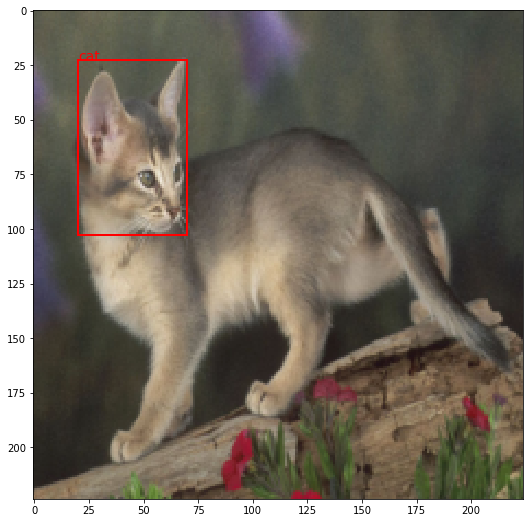

In [13]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);
    

imshow(sample['image'],sample['label'],sample['bbox'])

In [14]:
from torchvision.models import resnet18, ResNet18_Weights

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################
        
        self.resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)
        num_ftrs = self.resnet18.fc.in_features
        self.res18_fc_removed = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))
        
        for param in self.res18_fc_removed.parameters():
            param.requires_grad = False
            
        self.fc_classifier = nn.Sequential(nn.Flatten(),
                                           nn.Linear(num_ftrs, 10),
                                           nn.ReLU(),
                                           nn.Linear(10, num_classes))
        self.fcbbox = nn.Sequential(nn.Flatten(),
                                    nn.Dropout(0.5),
                                    nn.Linear(num_ftrs, 256),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.5),
                                    nn.Linear(256, 4),
                                    nn.Sigmoid())

    
    def forward(self, images):
        #############################################################################
        # Define the forward propagation. We need to pass an image through the      #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and bounding box coordinates.   #
        #############################################################################
        
        x = self.res18_fc_removed(images)
        classifier = self.fc_classifier(x)
        bbox = self.fcbbox(x)
        return classifier, bbox

## Guidelines and tips

1. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). An implementation of the IoU metric in the file `data\dataloader.py`.
2. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
3. You are encouraged to try Google Colab. If you have CUDA capable GPU at home - you are welcome to use it.
4. We should try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.

In [15]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0
    best_epoch = 0
    train_acc, val_acc, train_loss, val_loss, train_IoU, val_IoU = [], [], [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()     # Set model to training mode
            else:
                model.eval()      # Set model to evaluate mode

            running_loss = 0.0    # total loss of the network at each epoch
            running_corrects = 0  # number of correct predictions
            iou = 0.0             # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                inputs = sample.get('image')
                labels = sample.get('label')
                bboxs = sample.get('bbox')
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                bboxs = bboxs.to(device)
                
                optimizer.zero_grad()                                                      # initialize gradients to zero
                class_pred, bbox_pred = model.forward(inputs)                              # forward calc
                loss_class = criterion_cls(class_pred, labels)                             # classifier loss
                loss_bb = criterion_bbox(bbox_pred, bboxs)                                 # bbox regression loss
                _ , predicted = torch.max(class_pred.data, 1)
                running_corrects += torch.sum(predicted == labels)                         # accumulate correct class preds
                batch_loss = loss_class + loss_bb/10                                       # loss calc
                if phase == 'train':
                    batch_loss.backward()                                                  # backward calc
                    optimizer.step()       
                    
                running_loss += batch_loss * inputs.size(0)                                # numeric loss
                for i in range(bboxs.shape[0]):
                    iou += bb_intersection_over_union(bbox_pred[i], bboxs[i])

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))
            
            # update epoch data for visualization 
            if phase == 'train':
                train_acc.append(epoch_acc.detach().numpy())
                train_loss.append(epoch_loss.detach().numpy())
                train_IoU.append(iou)
            else:
                val_acc.append(epoch_acc.detach().numpy())
                val_loss.append(epoch_loss.detach().numpy())
                val_IoU.append(iou)
        
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch+1

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, val_acc, train_loss, val_loss, train_IoU, val_IoU, best_epoch

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [16]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = nn.CrossEntropyLoss(reduction="mean")                   
criterion_bbox = nn.SmoothL1Loss(reduction="mean")    
parameters = filter(lambda p: p.requires_grad, cnn.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.008)

In [17]:
best_model, train_acc, val_acc, train_loss, val_loss, train_IoU, val_IoU, best_epoch = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.3586  |  Acc: 0.7909  |  IOU: 0.5599
val Loss: 0.1082  |  Acc: 0.9557  |  IOU: 0.6940
Epoch 2/10
----------
train Loss: 0.0919  |  Acc: 0.9670  |  IOU: 0.7138
val Loss: 0.0477  |  Acc: 0.9873  |  IOU: 0.7578
Epoch 3/10
----------
train Loss: 0.0570  |  Acc: 0.9780  |  IOU: 0.7334
val Loss: 0.0337  |  Acc: 0.9873  |  IOU: 0.7673
Epoch 4/10
----------
train Loss: 0.0531  |  Acc: 0.9827  |  IOU: 0.7419
val Loss: 0.0406  |  Acc: 0.9810  |  IOU: 0.7532
Epoch 5/10
----------
train Loss: 0.0329  |  Acc: 0.9906  |  IOU: 0.7404
val Loss: 0.0296  |  Acc: 0.9873  |  IOU: 0.7660
Epoch 6/10
----------
train Loss: 0.0273  |  Acc: 0.9921  |  IOU: 0.7438
val Loss: 0.0807  |  Acc: 0.9684  |  IOU: 0.7657
Epoch 7/10
----------
train Loss: 0.0438  |  Acc: 0.9858  |  IOU: 0.7454
val Loss: 0.0257  |  Acc: 0.9873  |  IOU: 0.7705
Epoch 8/10
----------
train Loss: 0.0228  |  Acc: 0.9921  |  IOU: 0.7486
val Loss: 0.0334  |  Acc: 0.9747  |  IOU: 0.7678
Epoch 9/10
----------
tr

Let's see how the model can predict and localize cats and dogs!

<Figure size 864x576 with 0 Axes>

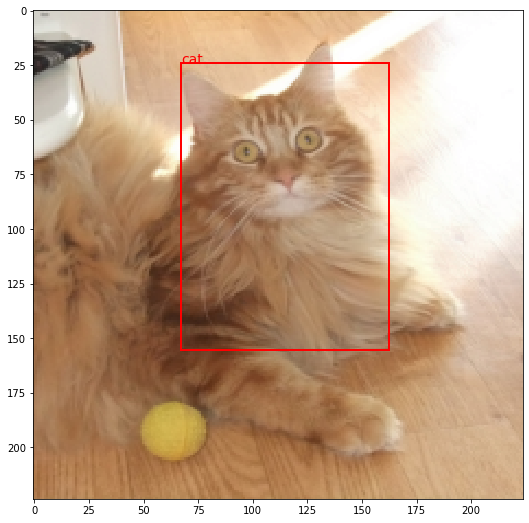

In [18]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

**Result conclusions:**
1. It is apparent that classification accuracy is high, IoU score seems to plateau around 0.75, this could be due to small training set with incoherent bounding boxes. I tried many different architectures, optimizers, loss functions and hyper params, the best results went to a mixed implementation of the models referenced in these articals : <br>
https://teaching.pages.centralesupelec.fr/deeplearning-lectures-build/01-pytorch-object-detection.html
https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc

2. Below are some visualizations of the learning proccess. On the accuracy graph, where the model yeilded the highest validation accuracy is shown where the best model was 'frozen'.

**Visualizing the best model results (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch).**

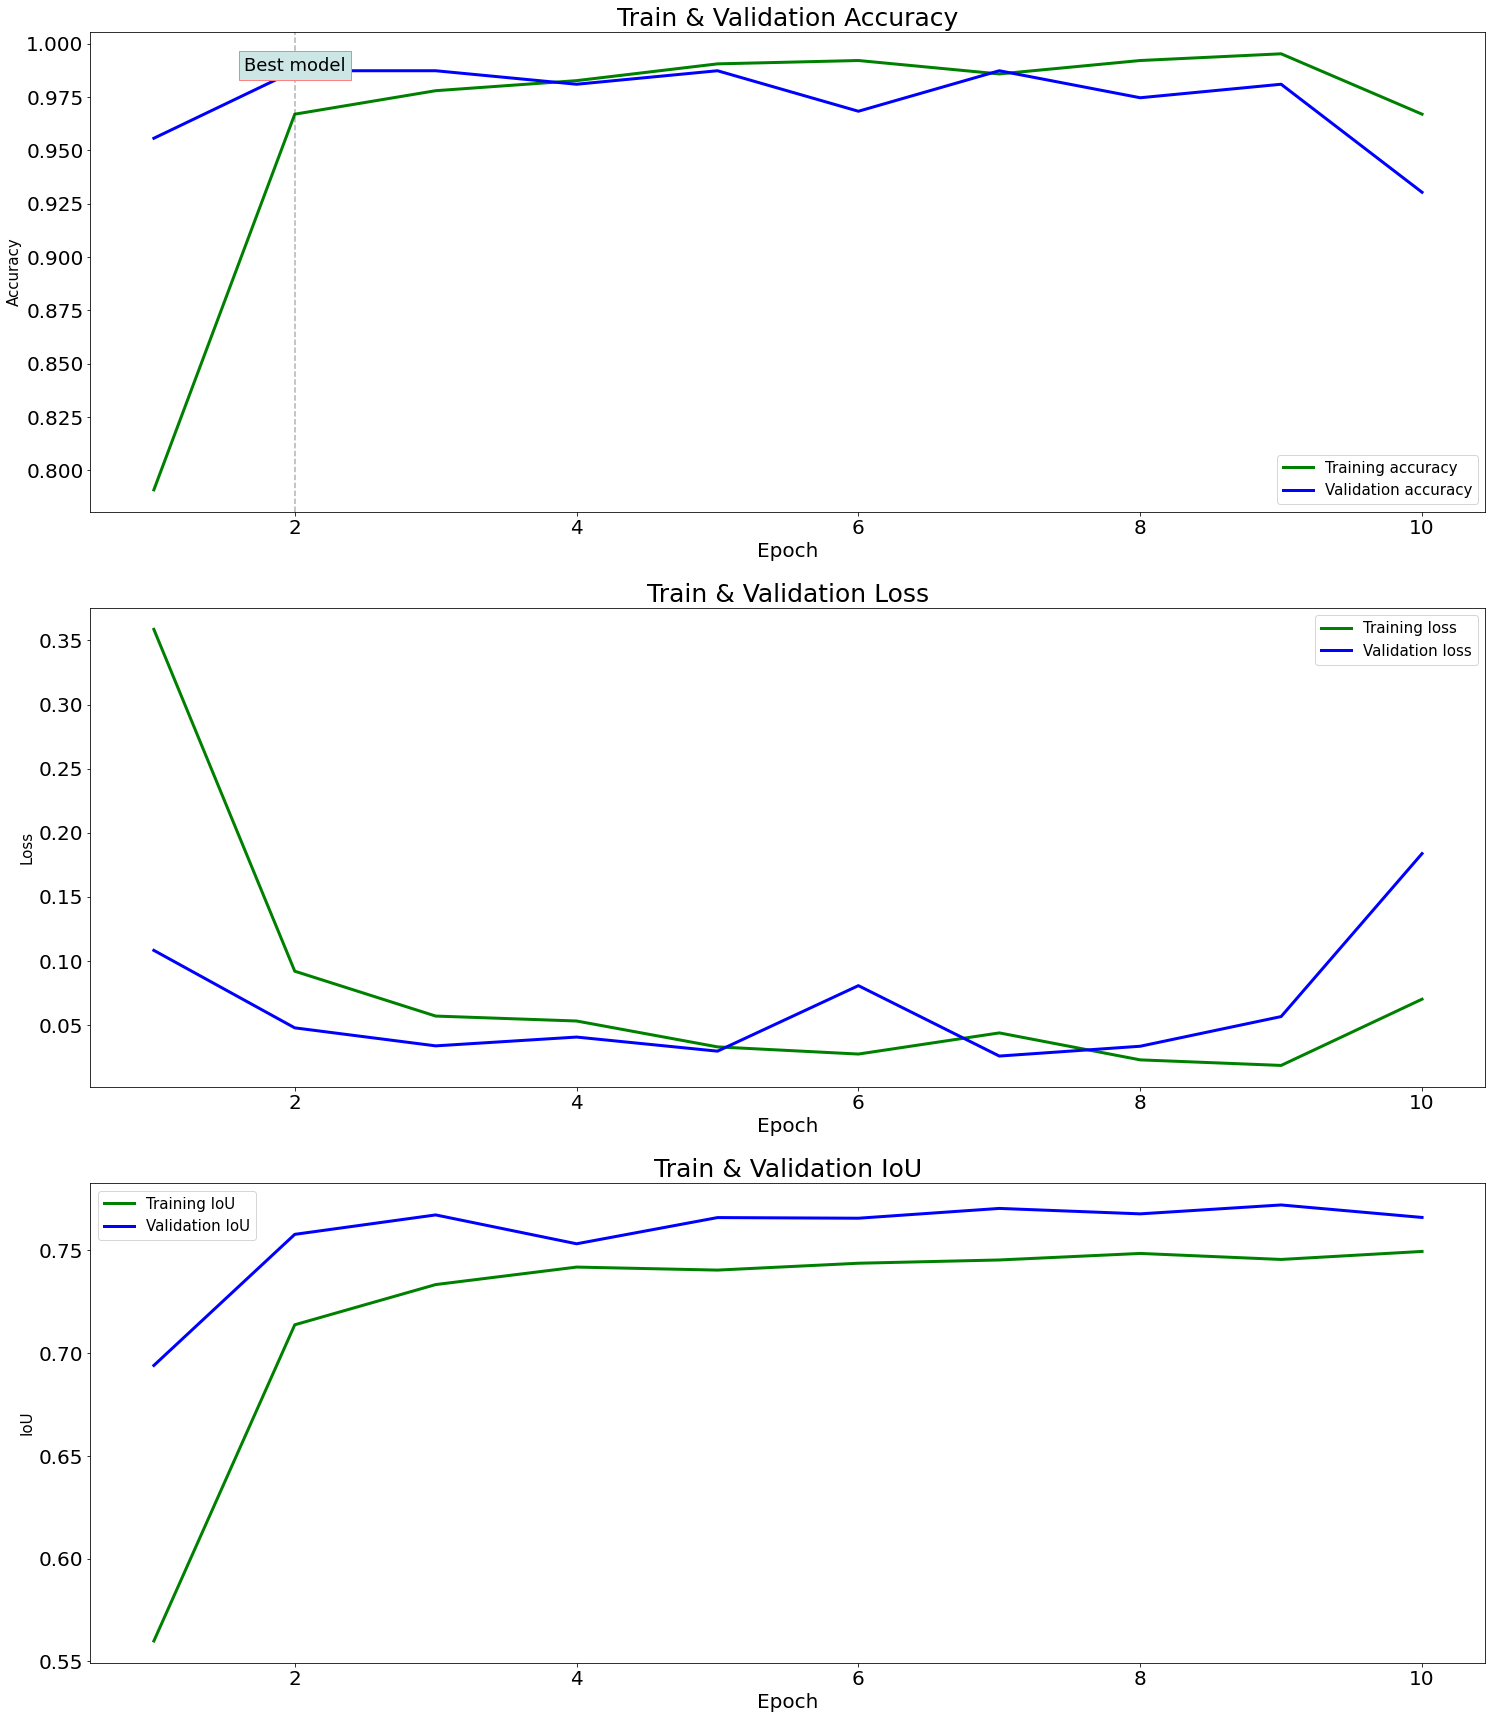

In [19]:
epochs = range(1,11)
fig, ax = plt.subplots(3,1, figsize=(25, 30))

ax[0].set_xlabel('Epoch',fontsize="20")
ax[0].tick_params(labelsize=20)
ax[0].set_ylabel('Accuracy', fontsize="15")
ax[0].set_title('Train & Validation Accuracy',fontsize="25")
ax[0].plot(epochs, train_acc, 'g', linewidth=3, label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', linewidth=3, label='Validation accuracy')
ax[0].legend(fontsize="15")
ax[0].axvline(best_epoch, color='k', linestyle='--', alpha=0.3)
ax[0].text(best_epoch,val_acc[best_epoch-1],'Best model',fontsize=18,horizontalalignment='center',
        bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(0.8, 0.9, 0.9),))

ax[1].set_xlabel('Epoch',fontsize="20")
ax[1].tick_params(labelsize=20)
ax[1].set_ylabel('Loss', fontsize="15")
ax[1].set_title('Train & Validation Loss',fontsize="25")
ax[1].plot(epochs, train_loss, 'g', linewidth=3, label='Training loss')
ax[1].plot(epochs, val_loss, 'b', linewidth=3, label='Validation loss')
ax[1].legend(fontsize="15")

ax[2].set_xlabel('Epoch',fontsize="20")
ax[2].tick_params(labelsize=20)
ax[2].set_ylabel('IoU', fontsize="15")
ax[2].set_title('Train & Validation IoU',fontsize="25")
ax[2].plot(epochs, train_IoU, 'g', linewidth=3, label='Training IoU')
ax[2].plot(epochs, val_IoU, 'b', linewidth=3, label='Validation IoU')
ax[2].legend(fontsize="15")

plt.show()